<img src="images/header.png" title="stock_flex" align="center">

---

### Import Dependancies
Import system, data analytics, finance API, database tools, and visualization libraries

In [1]:
# System
import os
import time, sys
from pathlib import Path
from dotenv import load_dotenv
import requests
from datetime import date, datetime, timedelta
from ast import literal_eval as make_tuple

# Data analytics
import pandas as pd
from pandas import DataFrame, MultiIndex
from typing import List, NewType
import numpy as np

# Visualization
import panel as pn
import panel.widgets as pnw
import plotly.express as px
import plotly.graph_objects as go
pn.extension('plotly')
pn.extension()
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns

# Finance
import alpaca_trade_api as tradeapi
import quandl as ql
import finnhub

import warnings
warnings.filterwarnings('ignore')

# Local dependancies
import MyPortfolioSimulator


Bad key "text.kerning_factor" on line 4 in
/Users/nfroemm/Code/anaconda3/envs/pyvis-py37-try2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


---

## Data Connections
- Static Data Connections
- Dynamic Data Connections

### Static Data Connections

##### Stock Ticker Lists

In [2]:
# Get tickers within S&P500 index
sp500_tickers_path = Path('resources/sp500_tickers.csv')
sp500_tickers = pd.read_csv(sp500_tickers_path).sort_values(by="Symbol")

In [3]:
# S&P 500 ticker list test
sp500_tickers.head(10)

Symbol                 Security             GICS Sector  \
11      A     Agilent Technologies             Health Care   
28    AAL  American Airlines Group             Industrials   
8     AAP       Advance Auto Parts  Consumer Discretionary   
45   AAPL               Apple Inc.  Information Technology   
2    ABBV              AbbVie Inc.             Health Care   
35    ABC        AmerisourceBergen             Health Care   
3    ABMD                  Abiomed             Health Care   
1     ABT      Abbott Laboratories             Health Care   
4     ACN                Accenture  Information Technology   
6    ADBE               Adobe Inc.  Information Technology   

                             GICS Sub-Industry       Headquarters Location  \
11                       Health Care Equipment     Santa Clara, California   
28                                    Airlines           Fort Worth, Texas   
8                            Automotive Retail     Raleigh, North Carolina   
45  Technology Hardware, Storage & Peripherals       Cupertino, California   
2                              Pharmaceuticals     North Chicago, Illinois   
35                    Health Care Distributors  Chesterbrook, Pennsylvania   
3                        Health Care Equipment      Danvers, Massachusetts   
1                        Health Care Equipment     North Chicago, Illinois   
4               IT Consulting & Other Services             Dublin, Ireland   
6                         Application Software        San Jose, California   

   Date first added      CIK      Founded  
11         6/5/2000  1090872         1999  
28        3/23/2015     6201         1934  
8          7/9/2015  1158449         1932  
45       11/30/1982   320193         1977  
2        12/31/2012  1551152  2013 (1888)  
35        8/30/2001  1140859         1985  
3         5/31/2018   815094         1981  
1         3/31/1964     1800         1888  
4          7/6/2011  1467373         1989  
6          5/5/1997   796343         1982

In [4]:
# Get fundamental data from csv
stock_fundamentals_data_path = Path("resources/fundamental_data.csv")
stock_fundamentals_df = pd.read_csv(stock_fundamentals_data_path)

In [5]:
# Fundamental values test
stock_fundamentals_df.head()

symbol                 metric_type    metric series
0    MMM   10DayAverageTradingVolume   2.38516    NaN
1    MMM      13WeekPriceReturnDaily  14.79371    NaN
2    MMM      26WeekPriceReturnDaily  25.77423    NaN
3    MMM  3MonthAverageTradingVolume  49.80709    NaN
4    MMM                  52WeekHigh   203.155    NaN

### Dynamic Data Connections

#### API Keys

In [6]:
# Load API keys
api_key_path = Path('resources/api_keys.env')  # replace with `/path/to/your/api_keys.env`
load_dotenv(api_key_path)

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Set FinnHub API key
finnhub_api_key = os.getenv("FINNHUB_API_KEY")

# Check API keys are of the correct type (`str`)
print('API KEYS')
print('--------')
print(f"alpaca_api_key: {type(alpaca_api_key)}")
print(f"alpaca_secret_key: {type(alpaca_secret_key)}")
print(f"finnhub_api_key: {type(finnhub_api_key)}")
print()

API KEYS
--------
alpaca_api_key: <class 'str'>
alpaca_secret_key: <class 'str'>
finnhub_api_key: <class 'str'>



#### Alpaca API: Stock price data on demand

In [7]:
# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

#### FinnHub API: Stock fundamentals data on demand

In [8]:
# Create FinnHub API object
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

# Method to obtain json data from FinnHub
def finnhub_data(ticker):
    
    data = finnhub_client.company_basic_financials(ticker, "")
    data_df = pd.DataFrame(data)
    time.sleep(1)
    
    return data_df

#### Bond Data

In [9]:
# Treasury bonds
def treasury_data():
    return ql.get("USTREASURY/YIELD")

In [10]:
# Quandl treasure data test
treasury_data().head()

1 MO  2 MO  3 MO  6 MO  1 YR  2 YR  3 YR  5 YR  7 YR  10 YR  \
Date                                                                      
1990-01-02   NaN   NaN  7.83  7.89  7.81  7.87  7.90  7.87  7.98   7.94   
1990-01-03   NaN   NaN  7.89  7.94  7.85  7.94  7.96  7.92  8.04   7.99   
1990-01-04   NaN   NaN  7.84  7.90  7.82  7.92  7.93  7.91  8.02   7.98   
1990-01-05   NaN   NaN  7.79  7.85  7.79  7.90  7.94  7.92  8.03   7.99   
1990-01-08   NaN   NaN  7.79  7.88  7.81  7.90  7.95  7.92  8.05   8.02   

            20 YR  30 YR  
Date                      
1990-01-02    NaN   8.00  
1990-01-03    NaN   8.04  
1990-01-04    NaN   8.04  
1990-01-05    NaN   8.06  
1990-01-08    NaN   8.09

---

## Data Parsing

##### Stock Data Parsing Methods
A collection of methods for parsing S&P 500 tickers, calling Alpaca Trade API, and querying stock_prices.db database

#### Alpaca API Methods

In [11]:
# List of dates between two user selected dates
def list_of_dates_between_two_dates(start_date,
                                    end_date):  
    '''
    Helper function to ger a range of dates between two dates
    '''
    return (pd.date_range(start_date, end_date-timedelta(days=1), freq='d').strftime("%Y-%m-%d").to_list())

In [12]:
start_date = date.fromisoformat('2015-01-01')
end_date = date.fromisoformat('2015-02-01')

list_of_dates_between_two_dates(start_date, end_date)

['2015-01-01',
 '2015-01-02',
 '2015-01-03',
 '2015-01-04',
 '2015-01-05',
 '2015-01-06',
 '2015-01-07',
 '2015-01-08',
 '2015-01-09',
 '2015-01-10',
 '2015-01-11',
 '2015-01-12',
 '2015-01-13',
 '2015-01-14',
 '2015-01-15',
 '2015-01-16',
 '2015-01-17',
 '2015-01-18',
 '2015-01-19',
 '2015-01-20',
 '2015-01-21',
 '2015-01-22',
 '2015-01-23',
 '2015-01-24',
 '2015-01-25',
 '2015-01-26',
 '2015-01-27',
 '2015-01-28',
 '2015-01-29',
 '2015-01-30',
 '2015-01-31']

In [13]:
# Get prices for tickers withing a given index or sector
def stock_prices_from_api(ticker_list, start_date, end_date):
    '''Returns pd.DataFrame with prices for the given tickers
    
    ...
    
    Parameters
    ----------
    tickers_list : list() - list of str() of tickers
    start_date : str() - string with date in following format YYYY-MM-DD
    end_date: str() - string with date in following format YYYY-MM-DD 
    
    
    Returns
    -------
    result_df : pd.DataFrame with securities price data
    '''
   
    # Get list of tickers from the tickers_df list or tickers_df DataFrame 
    tickers = ticker_list
    
    # Parse start and end dates
    start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()
    end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
    
    # Connect to Alpaca API and get data
    """Condition handling: Alpaca API 422 Client Error if more than 100 tickers are passed"""
    
    
    # a. Alpaca API condition handling, sending 100 tickers at a time
    # Declate a pd.DataFrame
    result_df = pd.DataFrame()
    tickers_n = 50
    
    for i in range(0, len(tickers), tickers_n):
        # Slice the ticker list into lists of 50 tickers
        sliced_tickers = tickers[i:i + tickers_n] 
        
        temp_df = api.get_barset(
        sliced_tickers,
        timeframe = "1D",
        start = start_date,
        end = end_date,
        limit = 1000).df

        # Append temporary dataframe to result_df
        result_df = pd.concat([result_df, temp_df], axis = "columns", join = "outer")
        time.sleep(0.1)
        
    return result_df

In [14]:
# Alpaca Trade API stock data test
stock_prices = stock_prices_from_api(list(sp500_tickers.head(10)["Symbol"]), '2016-05-01', '2021-05-13')
stock_prices

A                                          \
                             open      high       low    close     volume   
time                                                                        
2017-05-19 00:00:00-04:00     NaN       NaN       NaN      NaN        NaN   
2017-05-22 00:00:00-04:00     NaN       NaN       NaN      NaN        NaN   
2017-05-23 00:00:00-04:00     NaN       NaN       NaN      NaN        NaN   
2017-05-24 00:00:00-04:00   58.50   59.3400   58.0725   59.230  3552255.0   
2017-05-25 00:00:00-04:00   59.53   59.7000   58.9200   59.310  1831759.0   
2017-05-26 00:00:00-04:00   59.23   59.7200   59.0410   59.510  1075800.0   
2017-05-30 00:00:00-04:00   59.54   60.4800   59.4400   60.380  2270324.0   
2017-05-31 00:00:00-04:00   59.45   60.8100   59.4500   60.330  1709007.0   
2017-06-01 00:00:00-04:00   60.01   60.7700   59.8100   60.730  1775243.0   
2017-06-02 00:00:00-04:00   60.80   61.1500   60.7600   60.810  1344846.0   
2017-06-05 00:00:00-04:00   60.85   60.8500   60.3300   60.410  1226238.0   
2017-06-06 00:00:00-04:00   60.14   60.5450   60.1000   60.100  1236902.0   
2017-06-07 00:00:00-04:00   60.26   60.7650   59.9800   60.630  1282222.0   
2017-06-08 00:00:00-04:00   60.62   60.7250   59.7100   60.130  2987841.0   
2017-06-09 00:00:00-04:00   60.31   60.4500   59.1300   59.210  1978154.0   
2017-06-12 00:00:00-04:00   59.14   59.4100   57.9200   59.000  2334914.0   
2017-06-13 00:00:00-04:00   59.07   59.6400   58.9300   59.290  1252531.0   
2017-06-14 00:00:00-04:00   59.54   59.7800   59.0500   59.370   919840.0   
2017-06-15 00:00:00-04:00   59.22   59.2900   58.8200   59.210   880156.0   
2017-06-16 00:00:00-04:00   59.37   59.7900   59.2350   59.520  1478167.0   
2017-06-19 00:00:00-04:00   59.58   60.6700   59.5800   60.520  1462019.0   
2017-06-20 00:00:00-04:00   60.55   60.9200   60.2950   60.330  1576150.0   
2017-06-21 00:00:00-04:00   60.08   60.5300   59.6700   59.795  1956024.0   
2017-06-22 00:00:00-04:00   59.94   60.8000   59.6100   60.600  2973537.0   
2017-06-23 00:00:00-04:00   60.59   60.5900   59.5001   59.770  2023714.0   
2017-06-26 00:00:00-04:00   59.79   59.9500   59.1500   59.230  1151637.0   
2017-06-27 00:00:00-04:00   59.13   59.5700   58.8400   58.870   822880.0   
2017-06-28 00:00:00-04:00   59.27   59.7000   59.2000   59.380   929953.0   
2017-06-29 00:00:00-04:00   59.35   59.6300   58.4900   58.800  1126942.0   
2017-06-30 00:00:00-04:00   59.00   59.5700   58.8350   59.320  1175093.0   
...                           ...       ...       ...      ...        ...   
2021-04-01 00:00:00-04:00  128.00  128.3000  127.0050  127.730   951475.0   
2021-04-05 00:00:00-04:00  129.00  130.6100  129.0000  130.010   920658.0   
2021-04-06 00:00:00-04:00  130.57  131.8600  129.8700  131.030  1253660.0   
2021-04-07 00:00:00-04:00  130.25  130.5700  128.5300  129.360   715109.0   
2021-04-08 00:00:00-04:00  130.59  131.7300  129.8735  130.680   733630.0   
2021-04-09 00:00:00-04:00  131.46  131.9200  130.7343  131.900  1140335.0   
2021-04-12 00:00:00-04:00  131.44  132.1800  130.8400  131.270   959328.0   
2021-04-13 00:00:00-04:00  131.60  133.2670  131.4700  132.980  1407882.0   
2021-04-14 00:00:00-04:00  133.10  133.2250  130.9610  131.960  1115626.0   
2021-04-15 00:00:00-04:00  132.00  133.9400  132.0000  133.290  1880996.0   
2021-04-16 00:00:00-04:00  134.05  134.6400  133.1600  134.580  1957568.0   
2021-04-19 00:00:00-04:00  134.52  134.6500  133.0700  133.590   811198.0   
2021-04-20 00:00:00-04:00  133.00  133.5500  131.8150  132.440  1049959.0   
2021-04-21 00:00:00-04:00  132.88  133.9500  132.0200  133.860   934491.0   
2021-04-22 00:00:00-04:00  134.03  135.4550  133.8300  134.520  1521009.0   
2021-04-23 00:00:00-04:00  134.57  137.1200  134.5000  136.670  1231502.0   
2021-04-26 00:00:00-04:00  137.21  137.8271  136.6800  137.340   975165.0   
2021-04-27 00:00:00-04:00  136.93  137.4400  136.2300  136.480  1120312.0   
2021-04-28 00:00:00-04:00  1

In [15]:
# Multiindex slicing
idx = pd.IndexSlice
index = list(stock_prices.transpose().index.get_level_values(0))
formatted_stock_prices = stock_prices.xs('close', axis=1, level=1, drop_level=False).droplevel(1, axis=1)
formatted_stock_prices.head()

A    AAL     AAP    AAPL   ABBV    ABC    ABMD  \
time                                                                            
2017-05-19 00:00:00-04:00    NaN    NaN     NaN     NaN    NaN  89.17  134.42   
2017-05-22 00:00:00-04:00    NaN    NaN     NaN     NaN    NaN  89.50  135.76   
2017-05-23 00:00:00-04:00    NaN    NaN  140.59     NaN    NaN  89.24  134.73   
2017-05-24 00:00:00-04:00  59.23  46.78  132.95  153.30  63.77  89.99  134.89   
2017-05-25 00:00:00-04:00  59.31  47.61  131.96  153.91  66.33  91.11  135.82   

                             ABT     ACN    ADBE  
time                                              
2017-05-19 00:00:00-04:00    NaN     NaN     NaN  
2017-05-22 00:00:00-04:00    NaN     NaN  138.88  
2017-05-23 00:00:00-04:00    NaN     NaN  139.55  
2017-05-24 00:00:00-04:00  43.53  121.95  141.13  
2017-05-25 00:00:00-04:00  43.95  123.07  142.85

#### Local <code>stock_price.db</code> Database Methods

In [16]:
# Rebuilds database for Alpaca API stock prices if necessary
def create_stock_prices_db():
    '''This method creates a SQLite database that will store all of ticker daily prices;
    This method is created to resolve the Alpaca API request limits that can greatly slow down large data requests
    '''
    
    print("This will restore the 'stock_prices' database and delete all of stored values, are you sure? y/[n]")

    conn = sqlite3.connect('resources/stock_prices.db')
    
    
# Seed stock price database
def seed_stock_prices_database(tickers_df):
    '''Seeds stock_prices database that houses all prices for tickers within an index or sector'''

    # Get data for dates indicated
    data = stock_prices_from_api(tickers_df, "2015-01-01", "2018-01-01")
    
    # Transpose dataframe
    data = data.transpose()
    
    # Connect to databse
    conn = sqlite3.connect('resources/stock_prices.db') 
    c = conn.cursor()
    
    # Iterate over dataframe and populate the database
    for ticker, sub_frame in data.groupby(level=0):
        
        ticker = "_" + ticker.replace('.','_')
        
        list_of_tables = c.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{ticker}';").fetchall()
        if list_of_tables == []:
            sub_frame.transpose().to_sql(ticker, conn, if_exists='append')
        else:
            sub_frame.transpose().to_sql(ticker, conn, if_exists='append')
    
    conn.commit()
    conn.close()

    

# Update stock price database     
def update_stock_prices_database(tickers_df):
    '''Updates stock_prices database that houses all prices for tickers within an index or sector'''
    
    # Get today's date
    today_date = date.today().strftime("%Y-%m-%d")
    
    # Connect to databse
    conn = sqlite3.connect('resources/stock_prices.db') 
    c = conn.cursor()
    
    # Iterate over dataframe and populate the database
    ticker_count = 0
    for index, ticker_data in tickers_df.iterrows():
        
        ticker = "_" + ticker_data["Symbol"].replace('.','_')
        
        # Get list of all tables in databse
        list_of_tables = c.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{ticker}';").fetchall()
        
        # If table does not exist, create and seed
        if list_of_tables == []: # If tables does not exist
            # Get data from Alpaca API
            data = stock_prices_from_api(ticker_data, "2015-01-01", "2018-01-01")
            
            # Write stock data to databse
            data.to_sql(ticker, conn, if_exists='append')
            
        else: # If table does exist
            try:
                # Get last date from the table
                last_date = c.execute(f"SELECT time FROM {ticker} ORDER BY time DESC LIMIT 1").fetchall()
                last_date = ''.join(last_date[0]).split(" ")[0]

                # Get next date
                next_date = datetime.strptime(last_date, '%Y-%m-%d') + timedelta(days=1)

                # Change date format for Alpaca
                next_date = next_date.strftime("%Y-%m-%d")
                
                # Get today's date
                today_date = datetime.today().strftime("%Y-%m-%d")
                
                if last_date < today_date:

                    # Get data from Alpaca API
                    data = stock_prices_from_api(ticker_data, last_date, today_date)

                    # Write data to database
                    data.to_sql(ticker, conn, if_exists='append')
                
                else:
                    pass
            except:
                pass
            
        ticker_count += 1
    print(f"Processing {ticker} | {ticker_count}/{len(tickers_df.index)}")
    
    conn.commit()
    conn.close()
    
    
    
# Get stock prices from database
def stock_prices_from_db(ticker_df, start_date, end_date):
    '''Returns a pd.DataFrame with stock price data for tickers passed in ticker_df and 
    filtered by dates passed in start_date and end_date
    
    ...
    
    Parameters
    ----------
    tickers_df : pd.DataFrame - contains tickers for given index or sector under 
        the "Symbol" column which is the DataFrame key
    start_date : str() - string with date in following format YYYY-MM-DD
    end_date: str() - string with date in following format YYYY-MM-DD 
    
    
    Returns
    -------
    result_df : pd.DataFrame with securities price data
    '''
    # Connect to database
    conn = sqlite3.connect('resources/stock_prices.db') 
    c = conn.cursor()
    
    # Cast dates to pandas datetime
    start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()
    end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
    
    # Declare result_df
    result_df = pd.DataFrame()
    
    # Iterate over tickers
    for ticker in list(ticker_df["Symbol"]):
        
        try:
            # Parse ticker name
            _ticker = "_" + ticker.replace('.','_')

            # Query databse
            data = pd.read_sql_query(f"SELECT * FROM {_ticker}", conn)

            # Filter database by dates
            data = data[(data['time'] >= start_date) & (data['time'] <= end_date)].set_index(['time'])

            # Concatenate dataframes
            result_df = pd.concat([result_df, data], axis = "columns", join = "outer")
        
        except:
            print(f"Ticker {ticker} not found in database.")
        
    conn.commit()
    conn.close()
        
    # Create a multi-index 
    ## Transpose the df
    result_df = result_df.transpose()
    
    ## Get dataframe keys
    keys = []
    for key in result_df.index:
        keys.append(make_tuple(key))

    ## Build an index
    index = pd.MultiIndex.from_tuples(keys, names=('Symbol', 'Data'))

    ## Set index
    result_df = result_df.set_index(index).transpose()
        
    return result_df


# Get database date-range
def get_db_daterange():
    
    # Connect to database
    conn = sqlite3.connect('resources/stock_prices.db') 
    c = conn.cursor()
    
    last_date = pd.read_sql_query("SELECT time FROM _MSFT ORDER BY time DESC LIMIT 1", conn)['time'][0].split(" ")[0]
    
    first_date = pd.read_sql_query("SELECT time FROM _MSFT ORDER BY time ASC LIMIT 1", conn)['time'][0].split(" ")[0]
    
    
    conn.commit()
    conn.close()
    
    return (first_date, last_date)

def offline_application_set_up():
    '''Helper method - sets up offline access to Dashboard'''
    create_stock_prices_db()
    seed_stock_prices_database(sp500_tickers)
    update_stock_prices_database(sp500_tickers)

---

## Technical Methods

### Technical Data Methods

In [17]:
# RSI method : Calculate the RSI indicator
def rsi_table (df, days):
    '''Returns a pd.DataFrame with Relative Strength Index (RSI) column appended
        RSI formula = 100 – (100 / (1 + RS) or can also use 100 * up / (Up + Down)
        Where RS (relative strengh)  = Up / Down
        Where Up = rolling average price up over the time window obeserved
        Where Down = rolling average price down over the time window obeserved
    
        Parameters
        ----------
        df : pd.DataFrame - dataframe to be processed
        days : int() - numbers of days for RSI calcualtion
    
        Returns
        -------
        result_df : pd.DataFrame - dataframe with RSI column appended, calcualted daily for 
        timeperiod specified by days
    '''
    
    # Filter datafrance to clumn "close" only to facilitate the calculs
    stocks_close = df.iloc[:,df.columns.get_level_values(1)=='close']
    # Swap the column multilevel index to facilitate the calculs
    stocks_close = stocks_close.swaplevel(0,1,axis=1)
    
    # Calculate the movement on the price compared to the previous day closing price
    movement_1d = stocks_close - stocks_close.shift(1)
    movement_1d.rename(columns={'close':'movement_1d'}, level=0, inplace=True)

    # Define a sub-function to calculate the RSI
    def rsi (price):
        up = price[price>0].mean()
        down = abs(price[price<0]).mean()
        return 100 * up / (up + down)
        
    # Calculate the RSI and add it to a dataframe
    rsi_df = movement_1d.rolling(window=days).apply(rsi)
    rsi_df.rename(columns={'movement_1d':'RSI'}, level=0, inplace=True)
    
    # Remove the first dates that return NaN from the rolling days calculation
    rsi_df = rsi_df[days:]

    return rsi_df

In [18]:
# rsi_table test
days = 14
rsi_df = rsi_table(stock_prices, days)
rsi_df.to_csv("resources/rsi.csv")
rsi_df.head()

RSI                                   \
                                  A        AAL        AAP       AAPL   
time                                                                   
2017-06-09 00:00:00-04:00       NaN        NaN        NaN        NaN   
2017-06-12 00:00:00-04:00       NaN        NaN        NaN        NaN   
2017-06-13 00:00:00-04:00       NaN        NaN  36.952104        NaN   
2017-06-14 00:00:00-04:00  44.25656  58.013726  45.873874  29.791460   
2017-06-15 00:00:00-04:00  49.00000  54.305800  41.535577  32.391827   

                                                                       \
                                ABBV        ABC       ABMD        ABT   
time                                                                    
2017-06-09 00:00:00-04:00        NaN  61.182050  48.686371        NaN   
2017-06-12 00:00:00-04:00        NaN  60.945673  48.104623        NaN   
2017-06-13 00:00:00-04:00        NaN  58.778626  45.847449        NaN   
2017-06-14 00:00:00-04:00  50.821007  59.398496  49.009183  66.915052   
2017-06-15 00:00:00-04:00  44.578682  57.014925  48.329905  67.208272   

                                                 
                                 ACN       ADBE  
time                                             
2017-06-09 00:00:00-04:00        NaN        NaN  
2017-06-12 00:00:00-04:00        NaN  44.938272  
2017-06-13 00:00:00-04:00        NaN  48.647093  
2017-06-14 00:00:00-04:00  67.419189  48.439979  
2017-06-15 00:00:00-04:00  67.467195  46.984288

In [19]:
# MACD method : Calculate the MACD indicator with its Signal line
def macd_table(df, short_window, long_window, signal_window):
    ''' Moving Average Convergence Divergence (MACD) 
        Returns a pd.DataFrame with MACD and its Signal line column appended
        MACD formula = (12-day EMA - 26-day EMA)
        Signal line = MACD 9-day EMA
    
        Parameters
        ----------
        df : pd.DataFrame - dataframe to be processed
        short_ema : int() - short-term EMA for MACD calculation => default should be 12 days
        long_ema : int() - long-term EMA for MACD calculation => defaultshould be 26 days

        Returns
        -------
        result_df : pd.DataFrame - dataframe with MACD and Signal line column appended, calcualted daily for 
        timeperiod specified by days
    '''

    # Filter datafrance to clumn "close" only to facilitate the calculs
    stocks_close = df.iloc[:,df.columns.get_level_values(1)=='close']
    stocks_close = stocks_close.swaplevel(0,1,axis=1)
    
    # Define a sub-function to calculate the MACD
    def macd (price):
        short_ema = price.ewm(span=short_window, adjust=False).mean()
        long_ema = price.ewm(span=long_window, adjust=False).mean()
        macd_value = short_ema - long_ema
        return macd_value
    
    # Calculate the MACD and add it to a dataframe
    macd = stocks_close.apply(macd)
    macd.rename(columns={'close':'MACD'}, level=0, inplace=True)

    # Calculate the Signal line value
    signal = macd.ewm(span=9, adjust=False).mean()
    signal.rename(columns={'MACD':'MACD_Signal'}, level=0, inplace=True)
    
    # Concatenate/append both indicators to a new dataframe
    result_df = pd.concat([macd, signal], axis=1, join='inner')

    return result_df

In [20]:
# MACD method test
short_window = 12
long_window = 26
signal_window = 9
combined_macd = macd_table(stock_prices, short_window, long_window, signal_window)
combined_macd.to_csv("resources/macd.csv")
combined_macd.head()

MACD                                          \
                                  A       AAL       AAP      AAPL      ABBV   
time                                                                          
2017-05-19 00:00:00-04:00       NaN       NaN       NaN       NaN       NaN   
2017-05-22 00:00:00-04:00       NaN       NaN       NaN       NaN       NaN   
2017-05-23 00:00:00-04:00       NaN       NaN  0.000000       NaN       NaN   
2017-05-24 00:00:00-04:00  0.000000  0.000000 -0.609459  0.000000  0.000000   
2017-05-25 00:00:00-04:00  0.006382  0.066211 -1.158984  0.048661  0.204217   

                                                                             \
                                ABC      ABMD       ABT       ACN      ADBE   
time                                                                          
2017-05-19 00:00:00-04:00  0.000000  0.000000       NaN       NaN       NaN   
2017-05-22 00:00:00-04:00  0.026325  0.106895       NaN       NaN  0.000000   
2017-05-23 00:00:00-04:00  0.025909  0.107260       NaN       NaN  0.053447   
2017-05-24 00:00:00-04:00  0.085117  0.119088  0.000000  0.000000  0.220753   
2017-05-25 00:00:00-04:00  0.219880  0.201186  0.033504  0.089345  0.486525   

                          MACD_Signal                                          \
                                    A       AAL       AAP      AAPL      ABBV   
time                                                                            
2017-05-19 00:00:00-04:00         NaN       NaN       NaN       NaN       NaN   
2017-05-22 00:00:00-04:00         NaN       NaN       NaN       NaN       NaN   
2017-05-23 00:00:00-04:00         NaN       NaN  0.000000       NaN       NaN   
2017-05-24 00:00:00-04:00    0.000000  0.000000 -0.121892  0.000000  0.000000   
2017-05-25 00:00:00-04:00    0.001276  0.013242 -0.329310  0.009732  0.040843   

                                                                             
                                ABC      ABMD       ABT       ACN      ADBE  
time                                                                         
2017-05-19 00:00:00-04:00  0.000000  0.000000       NaN       NaN       NaN  
2017-05-22 00:00:00-04:00  0.005265  0.021379       NaN       NaN  0.000000  
2017-05-23 00:00:00-04:00  0.009394  0.038555       NaN       NaN  0.010689  
2017-05-24 00:00:00-04:00  0.024538  0.054662  0.000000  0.000000  0.052702  
2017-05-25 00:00:00-04:00  0.063607  0.083967  0.006701  0.017869  0.139467

In [21]:
# Bollinger Bands method : 
def bbands_table(df, length, numstd):
    '''Bollinger Bands (BB)
    returns average, upper band, and lower band
    
    Parameters
    ----------
    df : pd.DataFrame - dataframe to be processed
    lenght : int() - numer of prices we want to use to observe the average price 
    numstd : int() - number of Standard deviation we want to use to calculate the bands
    
    Returns
    -------
    result_df : pd.DataFrame - dataframe with RSI column appended, calcualted daily for 
    timeperiod specified by days
    '''
    
    # Filter datafrance to clumn "close" only to facilitate the calculs
    stocks_close = df.iloc[:,df.columns.get_level_values(1)=='close']
    stocks_close = stocks_close.swaplevel(0,1,axis=1)


    def bb_upband(price):
        #avg = pd.stats.moments.rolling_mean(price,length)
        avg = price.rolling(window= length).mean()
        #std = pd.stats.moments.rolling_std(price,length)
        std = price.rolling(window= length).std()

        upband = avg + (std*numstd)
        return np.round(upband,3)

    def bb_dnband(price):
        #avg = pd.stats.moments.rolling_mean(price,length)
        avg = price.rolling(window= length).mean()
        #std = pd.stats.moments.rolling_std(price,length)
        std = price.rolling(window= length).std()

        dnband = avg - (std*numstd)
        return np.round(dnband,3)

    bb_avg_df = stocks_close.rolling(window= length).mean()
    bb_avg_df.rename(columns={'close':'BB_Avg'}, level=0, inplace=True)
    
    bb_upband_df = stocks_close.apply(bb_upband)
    bb_upband_df.rename(columns={'close':'BB_Upband'}, level=0, inplace=True)

    bb_dnband_df = stocks_close.apply(bb_upband)
    bb_dnband_df.rename(columns={'close':'BB_Downband'}, level=0, inplace=True)

    # Concatenate/append both values to the original dataframe
    result_df = pd.concat([bb_avg_df, bb_dnband_df, bb_upband_df], axis=1, join='inner')

    return result_df

In [22]:
# Bollinger Band method test
length = 30
numstd = 2
combined_bb = bbands_table(stock_prices, length, numstd)
combined_bb.to_csv("resources/bb.csv")
combined_bb.tail()

BB_Avg                                     \
                                    A        AAL         AAP        AAPL   
time                                                                       
2021-05-07 00:00:00-04:00  131.970000  22.341000  192.820667  130.058583   
2021-05-10 00:00:00-04:00  132.178667  22.309667  193.525667  130.248250   
2021-05-11 00:00:00-04:00  132.377333  22.265247  194.166000  130.396890   
2021-05-12 00:00:00-04:00  132.505000  22.152913  194.684000  130.495073   
2021-05-13 00:00:00-04:00  132.599333  22.063083  195.384000  130.586407   

                                                                           \
                                 ABBV         ABC        ABMD         ABT   
time                                                                        
2021-05-07 00:00:00-04:00  109.572567  119.179667  324.259500  121.050167   
2021-05-10 00:00:00-04:00  109.912900  119.331333  323.627833  120.945167   
2021-05-11 00:00:00-04:00  110.183900  119.366667  322.779167  120.816500   
2021-05-12 00:00:00-04:00  110.457233  119.403000  321.504167  120.706333   
2021-05-13 00:00:00-04:00  110.736233  119.451667  319.622167  120.623333   

                                                   ... BB_Upband          \
                                  ACN        ADBE  ...         A     AAL   
time                                               ...                     
2021-05-07 00:00:00-04:00  286.590667  500.539367  ...   138.473  24.659   
2021-05-10 00:00:00-04:00  286.911667  500.882367  ...   138.224  24.620   
2021-05-11 00:00:00-04:00  287.190667  501.407700  ...   137.870  24.579   
2021-05-12 00:00:00-04:00  287.222000  501.641033  ...   137.417  24.419   
2021-05-13 00:00:00-04:00  287.518333  501.582367  ...   137.188  24.255   

                                                                        \
                               AAP     AAPL     ABBV      ABC     ABMD   
time                                                                     
2021-05-07 00:00:00-04:00  208.504  139.340  116.125  123.720  356.319   
2021-05-10 00:00:00-04:00  210.063  138.998  116.747  124.102  358.183   
2021-05-11 00:00:00-04:00  210.824  138.662  117.141  124.144  360.276   
2021-05-12 00:00:00-04:00  211.265  138.301  117.502  124.186  363.146   
2021-05-13 00:00:00-04:00  211.784  138.046  118.071  124.208  366.497   

                                                      
                               ABT      ACN     ADBE  
time                                                  
2021-05-07 00:00:00-04:00  124.766  296.126  534.711  
2021-05-10 00:00:00-04:00  124.715  296.320  533.936  
2021-05-11 00:00:00-04:00  124.659  296.180  532.854  
2021-05-12 00:00:00-04:00  124.867  296.091  532.060  
2021-05-13 00:00:00-04:00  124.946  295.431  532.217  

[5 rows x 30 columns]

In [23]:
def rsi_trader(tickers_list : list(), 
               lower_level : int(), 
               upper_level : int(), 
               start_date : str(), 
               end_date : str(), 
               rsi_range : int()):
    '''Returns a pd.DataFrame of a portoflio where position entry and exit are 
        determined by Relative Strength Index (RSI) values provided by the user.
    
        Parameters
        ----------
        tickers_list : list() - list of tickers to be traded
        lower_level : int() - lower level of RSI provided by user
        upper_level : int() - upper level of RSI provided by user
        start_date : str() - analysis start date string "YYYY-MM-DD"
        end_date : str() - analysis end date string "YYYY-MM-DD"
        rsi_range : int() - numbers of days for RSI calcualtion
    
        Returns
        -------
        result_df : pd.DataFrame - RSI traded portfolio
    '''
    
    # Get stock prices form Alpaca Trade API
    stock_prices = stock_prices_from_api(tickers_list, start_date, end_date)
    
    # Collapse multi-index to yield a single-index df with 'close' prices
    try:
        formatted_stock_prices = stock_prices.xs('close', axis=1, level=1, drop_level=False).droplevel(1, axis=1)
    except:
        formatted_stock_prices = pd.DataFrame({'time' : [datetime.strptime('2020-01-01', "%Y-%m-%d")], 'close' : [0.0]})
        print("RSI Portfolio Builder received an empty pd.DataFrame of stock prices")
        raise
        
    # Declare RSI df
    rsi_df = pd.DataFrame()   
    
    # Declare arbitrary cash position df and seed it
    cash_seed = 1000000.0
    cash_position = {}
    cash_position[0] = {'time' : formatted_stock_prices.index[0], 'close' : cash_seed}
    
    # Track long stock positions
    long_stock_position_tracker = {}
    for ticker in tickers_list:
        long_stock_position_tracker[ticker] = False
    
    # Build RSI trader positions over time
    ## iterate ticker colums
    for ticker in tickers_list:
        
        ### Declate dict for stock positions
        stock_seed = 0.0
        stock_position = {}
        stock_position[0] = {'time' : formatted_stock_prices.index[0], 'close' : stock_seed, 'rsi' : 0, 'stock_price' : 0, 'cash' : cash_seed/len(tickers_list)}
        
        ### generate df for ticker
        ticker_df = pd.DataFrame(formatted_stock_prices[ticker]).reset_index()

        # Calculate RSI
        delta = ticker_df[ticker].diff()
        move_up = delta.clip(lower=0)
        move_down = -1*delta.clip(upper=0)
        ema_up = move_up.ewm(com=rsi_range, adjust=False).mean()
        ema_down = move_down.ewm(com=rsi_range, adjust=False).mean()
        relative_strenght = ema_up/ema_down
        
        # add RSI to df
        ticker_df['rsi'] = 100 - (100/(1 + relative_strenght))
     
        # Skip first 14 days
        ticker_df = ticker_df.iloc[14:]
           
        #### iterate over the trading days
        for day in range(len(ticker_df.index)):
            ### get data for previous and current days and get RSI
            date = ticker_df.iloc[day,:]['time']
            stock_price = ticker_df.iloc[day,:][ticker]
            previous_day_rsi  = float(ticker_df.iloc[day-1, 2])
            current_day_rsi = float(ticker_df.iloc[day, 2])

            #### Trade logic - Open Long Position
            if previous_day_rsi < float(lower_level) and current_day_rsi > float(lower_level):

                ##### Check if long stock -> pass
                if long_stock_position_tracker[ticker] == True:
                    ## Adjust position
                    stock_position[day] = {'time' : date, 'close' : stock_position[day-1]['close'], 'rsi' : current_day_rsi,  'stock_price' : stock_price, 'cash' : stock_position[day-1]['cash']}


                #### Check if not long stock -> Go long
                elif long_stock_position_tracker[ticker] == False:
                    # Long position entry triggered

                    ## Adjust position
                    stock_adj = (cash_seed/len(tickers_list))/stock_price
                    cash_adj = 0

                    stock_position[day] = {'time' : date, 'close' : stock_adj, 'rsi' : current_day_rsi,  'stock_price'  : stock_price, 'cash' : cash_adj}

                    long_stock_position_tracker[ticker] = True

            ### Trade Logic - Close Long Position
            elif previous_day_rsi > float(upper_level) and current_day_rsi < float(upper_level):

                #### Check if not long stock -> pass
                if long_stock_position_tracker[ticker] == False:
                    ## Adjust position
                    try:
                        stock_position[day] = {'time' : date, 'close' : stock_position[day-1]['close'], 'rsi' : current_day_rsi,  'stock_price' : stock_price, 'cash' : stock_position[day-1]['cash']}
                    except:
                        stock_position[day] = {'time' : date, 'close' : 0, 'rsi' : current_day_rsi,  'stock_price' : stock_price, 'cash' : cash_seed/len(tickers_list)}

                #### Check if long stock -> Close long
                if long_stock_position_tracker[ticker] == True:
                    # Long position exit triggered
                    ## Adjust cash position
                    cash_adj = stock_position[day-1]['cash'] + stock_position[day-1]['close'] * stock_price
                    stock_adj = 0

                    stock_position[day] = {'time' : date, 'close' : stock_adj, 'rsi' : current_day_rsi,  'stock_price' : stock_price, 'cash' : cash_adj}

                    long_stock_position_tracker[ticker] = False

            ### Trade Logic - No Trade
            else:
                ## Adjust position
                try:
                    stock_position[day] = {'time' : date, 'close' : stock_position[day-1]['close'], 'rsi' : current_day_rsi,  'stock_price' : stock_price, "cash" : stock_position[day-1]['cash']}
                except:
                    stock_position[day] = {'time' : date, 'close' : 0, 'rsi' : current_day_rsi,  'stock_price'  : stock_price, 'cash' : cash_seed/len(tickers_list)}
                
        # Transpose stock_position_df   
        stock_position_df = pd.DataFrame(stock_position).transpose()
        
        # Set index to tim
        stock_position_df = stock_position_df.set_index('time')
        
        # Calculate stock_position_df positon value
        stock_position_df[ticker] = (stock_position_df['close'] * stock_position_df['stock_price']) + stock_position_df['cash']
        
        # Concatentate stock_position_df into master df
        rsi_df = pd.concat([rsi_df,stock_position_df[ticker]], axis='columns', join='outer')
    
    # Get total portfolio value
    rsi_portfolio_sum = rsi_df.sum(axis=1)/cash_seed-1

    return rsi_portfolio_sum

In [24]:
# RSI Trader method test
tickers = ['DLR','EQIX', 'PRU']

lower_level = 30
upper_level = 70
start_date = "2020-05-01"
end_date = "2021-05-01"
rsi_range = 14
rsi_trader(tickers, lower_level, upper_level, start_date, end_date, rsi_range).head()

2020-05-21 00:00:00-04:00    0.000000
2020-05-22 00:00:00-04:00    0.000000
2020-05-26 00:00:00-04:00    0.006038
2020-05-27 00:00:00-04:00    0.008492
2020-05-28 00:00:00-04:00    0.025207
dtype: float64

---

## FundamentalMethods

#### Fundamental Data Methods

In [25]:
# Get stock fundamental data from FinnHub
def generate_stock_fundamentals_from_finnhub(tickers_df):
    '''Returns pd.DataFrame with fundamentals of tickers within tickers_df
    
    ...
    Parameters
    ----------
    tickers_df : pd.DataFrame - contains tickers for given index or sector under 
        the "Symbol" column which is the DataFrame key
        
    Returns
    -------
    result_df : pd.DataFrame - securities fundamental data
    '''
    
    result_df = pd.DataFrame()
    
    
    for ticker in tickers_df['Symbol']:
        fundamental_data = finnhub_data(ticker)
        result_df = pd.concat([result_df, fundamental_data], axis='rows', join="outer")
        
        
    # Parse the dataframe
    result_df = result_df.reset_index().set_index('symbol')
    result_df = result_df.drop('metricType', 1)
    result_df.columns = ['metric_type', 'metric', 'series']
    
    return result_df

In [26]:
# Fundamental methods test
generate_stock_fundamentals_from_finnhub(sp500_tickers.head(10)).head()

metric_type   metric series
symbol                                            
A        10DayAverageTradingVolume  1.23572    NaN
A           13WeekPriceReturnDaily  2.41021    NaN
A           26WeekPriceReturnDaily  18.8048    NaN
A       3MonthAverageTradingVolume   34.424    NaN
A                       52WeekHigh  137.827    NaN

In [27]:
# Refresh stock fundamental data csv
def refresh_fundamentals_csv(tickers_df):
    '''Helper method - returns pd.DataFrame with fundamentals of tickers within tickers_df
    and/or calls to generate a refreashed dataset.
    
    Generates a CSV file with updated Fundamental values
    
    ...
    Parameters
    ----------
    tickers_df : pd.DataFrame - contains tickers for given index or sector under 
        the "Symbol" column which is the DataFrame key
    '''
    result_df = generate_stock_fundamentals_from_finnhub(tickers_df)
    result_df.to_csv("resources/fundamental_data.csv", mode='w')

In [28]:
# Fundamental data filter
def fundamental_data_query(tickers_df, stock_fundamentals_df, fundamental_indicator_keys):
    '''Returns a pd.DataFrame of fundamental data filtered by user input range
    
    ...
    
    Parameters
    ----------
    tickers_df : pd.DataFrame - dataframe to be processed, contains tickers
    fundamental_indicator_key : str() - keyword for fundamental indicator requested
    
        Fundamental indicator keys ->
        
        P/E Ratio : [pe_ratio]
        EPS (Earnings per Share) : [eps]
        Annual Dividend : [dividend]
        Beta (vs. S&P 500) : [beta]
        EBIDT : [ebidt]
        Quick Ratio : [quick_ratio]
        3 Year Revenue Growth : [rev_growth]
        Free Cash Flow : [cash_flow]
    
    lower_bound : int() or float() - lower bound for fundamental value filter, default = -1000000
    upper_bound : int() or float() - upper bound for fundamental value filter, default = 1000000
     
     
     
    Returns
    -------
    result_df : pd.DataFrame - dataframe with ticker and filtered fundamental data
    '''

    fund_indicators_dict = {
        'pe_ratio' : 'peNormalizedAnnual',
        'eps' : 'epsNormalizedAnnual',
        'dividend' : 'dividendsPerShareTTM',
        'beta' : 'beta',
        'ebidt' : 'ebitdPerShareTTM',
        'quick_ratio' : 'quickRatioAnnual',
        'rev_growth' : 'revenueGrowth3Y',
        'free_cash_flow' : 'freeCashFlowAnnual'   
    }

    # Declare result_df
    result_df = pd.DataFrame()
    
    # Declate tickers list
    tickers_list = tickers_df['Symbol']
    
    # Declare fundamental data df and filter by ticker df
    data_df = stock_fundamentals_df[stock_fundamentals_df.symbol.isin(tickers_list)]
    data_df = data_df.set_index(['symbol'])
    
    # Extract requested fundamental data
    for ind in fundamental_indicator_keys:
        df = data_df[data_df['metric_type'] == fund_indicators_dict[ind]]
        result_df = pd.concat([result_df, df], axis = 1, join = 'outer')
    
        # Clean up df
        result_df = result_df.drop(columns = ['metric_type', 'series'])
        result_df = result_df.rename(columns = {'symbol' : 'ticker', 
                                'metric' : ind})
        
            # Convert all df values to numeric
        result_df[ind] = result_df[ind].apply(pd.to_numeric)

    
    
    return result_df

In [29]:
# Fundamental data filter test
fundamental_values = fundamental_data_query(sp500_tickers, stock_fundamentals_df, ['eps', 'pe_ratio', 'dividend','ebidt','quick_ratio','rev_growth','free_cash_flow'])
fundamental_values.head()

eps  pe_ratio  dividend     ebidt  quick_ratio  rev_growth  \
symbol                                                                   
MMM     9.09138  22.15725      5.89  15.94172      1.35166     0.55185   
ABT     2.49663  47.07946      1.53   5.57856      1.29579     8.10890   
ABBV    3.65923  31.12677      4.72  11.21492      0.72792    17.52653   
ABMD    4.93771  60.91690      0.00   5.40404      5.48121    12.59419   
ACN     7.89470  36.93617      3.36  11.73871          NaN     7.00712   

        free_cash_flow  
symbol                  
MMM           3224.000  
ABT           3164.000  
ABBV          9074.000  
ABMD               NaN  
ACN           5580.822

### Fundamental Portfolio Methods

In [30]:
# Filter stocks by Dashboard selection
def filter_stocks_by_fundamentals(pe_range: tuple, 
                                  eps_range: tuple,
                                  dividend_range: tuple):
    '''
    '''
    
    # Filter PE and EPS
    min_pe = pe_range[0]
    max_pe = pe_range[1]
    
    min_eps = eps_range[0]
    max_eps = eps_range[1]
    
    min_dividend = dividend_range[0]
    max_dividend = dividend_range[1]
    
    # Filer fundamental_values dataframe by value range
    result_df = fundamental_values[(fundamental_values['eps'] >= min_eps) & 
                                   (fundamental_values['eps'] <= max_eps) & 
                                   
                                   (fundamental_values['pe_ratio'] >= min_pe) & 
                                   (fundamental_values['pe_ratio'] <= max_pe) &
                                   
                                   (fundamental_values['dividend'] >= min_dividend) & 
                                   (fundamental_values['dividend'] <= max_dividend)
                                  ]
    
    return result_df

In [31]:
# Filter stocks by Dashboard selection test
pe_range = (0,200)
eps_range = (0,200)
dividend_range = (4, 10)

filter_stocks_by_fundamentals(pe_range, eps_range, dividend_range).head()

eps  pe_ratio  dividend     ebidt  quick_ratio  rev_growth  \
symbol                                                                   
MMM     9.09138  22.15725      5.89  15.94172      1.35166     0.55185   
ABBV    3.65923  31.12677      4.72  11.21492      0.72792    17.52653   
APD     8.42947  34.71037      5.18  15.28327      3.42620     2.65148   
ARE     5.16840  35.00503      4.30   8.96597          NaN    18.67807   
AMT     5.01377  49.58345      4.53  16.09966          NaN     6.46401   

        free_cash_flow  
symbol                  
MMM           3224.000  
ABBV          9074.000  
APD           -347.900  
ARE          -3666.334  
AMT            921.500

In [32]:
# Build fundamental portfolio
def get_fundamental_portfolio(ticker_list,
                                start_date: str = "2020-01-01", 
                                end_date: str = "2021-05-01"):
    '''Returns pd.DataFrame weighted cumulative product portfolio
    
    ...
    Parameters
    ----------
    ticker_list : list - contains tickers to be processed
    start_date : str() - analysis start date string "YYYY-MM-DD"
    end_date : str() - analysis end date string "YYYY-MM-DD"
        
    Returns
    -------
    result_df : pd.DataFrame - dataframe with ticker and filtered fundamental data
    '''
    
    # Get stock prices for given stocks 
    stock_prices = stock_prices_from_api(ticker_list, start_date, end_date)
    
    idx = pd.IndexSlice
    index = list(stock_prices.transpose().index.get_level_values(0))
    try:
        formatted_stock_prices = stock_prices.xs('close', axis=1, level=1, drop_level=False).droplevel(1, axis=1)
    except:
        formatted_stock_prices = pd.DataFrame({'time' : ['2020_01_01'], 'close' : [0.0]})
    
    # For equal weight portfolio
    ntickers = len(ticker_list)
    weights = np.full(ntickers, (1.0 / ntickers))
    
    
    equal_weighted_portfolio = formatted_stock_prices.pct_change().dot(weights).cumsum().dropna()
        
    return equal_weighted_portfolio

In [33]:
# Build fundamental portfolio test
portfolio = pd.DataFrame(get_fundamental_portfolio(['AAPL','MSFT','TSLA'], "2020-01-01", "2021-05-01"))
portfolio = portfolio.rename(columns = {0 : 'close'})
portfolio.head()

close
time                               
2020-01-03 00:00:00-05:00  0.001705
2020-01-06 00:00:00-05:00  0.011812
2020-01-07 00:00:00-05:00  0.020278
2020-01-08 00:00:00-05:00  0.047388
2020-01-09 00:00:00-05:00  0.051480

In [34]:
# Fundumental portfolio plot
portfolio.hvplot(x='time',
                 y='close',
                 title='Fundamental Portfolio',
                 ylabel='Portfolio Returns, %',
                 height=700,
                 legend='right')

:Curve   [time]   (close)

In [35]:
# Diplay technical analysis plot
def display_technical_chart(ticker, ohlcv, rsi, macd, start_date, end_date):
    '''Ploting chart
        Returns 3 charts: RSI, Price/volume and MACD
    
        Parameters
        ----------
        ticker : str() - symbol of teh ticker we select
        ohlcv : pd.DataFrame - initial dataframe to be processed with open / high / low / close / volume
        rsi : pd.DataFrame - dataframe to be processed with RSI
        macd : pd.DataFrame - dataframe to be processed with MACD

        start_date : str() - string with date in following format YYYY-MM-DD
        end_date : str() - string with date in following format YYYY-MM-DD
    
        Returns
        -------
        3 charts
    '''
    
    
    ############# create a new DF filtered on one ticker ###############
    
    # Swap column levels for RSI_DF and MACD_DF to make sure we have the ticker in level 0
    rsi_df= rsi.swaplevel(0,1,axis=1)
    
    
    rsi_df_sliced= rsi_df.loc[start_date:end_date,ticker]
    macd_df= macd.swaplevel(0,1,axis=1)
    macd_df_sliced= macd_df.loc[start_date:end_date,ticker]
    ohlcv_df_sliced=ohlcv.loc[start_date:end_date,ticker]
    
    # Concat the dfs
    chart_ta_df = pd.concat([ohlcv_df_sliced, rsi_df_sliced, macd_df_sliced], axis=1, join='inner')

    
    #################### Chart ######################
    
    
    # Create the figure
    fig = plt.figure(figsize=(15,10))
   
    # Create the first subplot = Price
    ax1 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4)
    ax1 = chart_ta_df['close'].plot(color='b', label='Price')
    ax1.grid(True, color='c', linestyle='--')
    ax1.yaxis.label.set_color("k")
    ax1.tick_params(axis='y', colors='k')
    ax1.tick_params(axis='x', colors='k')
    ax1.set_facecolor('w')
    plt.ylabel('Stock price and Volume')
   
    # Add the volume within the same subplot
    # Retrieve volumes into a list
    volume = chart_ta_df['volume']
    # Share the same x-axis
    ax1v= ax1.twinx()
    ax1v.fill_between(chart_ta_df.index, volume,0, color='darkturquoise', alpha=0.5, label='Volume')
    # To avoid having a second grid overlaping the first one
    ax1v.grid(False)
    # Set the limit for the second y-axis and make it look smaller by multiplying the max volume
    ax1v.set_ylim(0, 3*volume.max())
    ax1v.axes.yaxis.set_ticklabels([])
    ax1v.tick_params(axis='y', colors='k')
    ax1v.yaxis.label.set_color("k")
    ax1v.spines['bottom'].set_color('midnightblue')
    ax1v.spines['top'].set_color('midnightblue')
    ax1v.spines['left'].set_color('midnightblue')
    ax1v.spines['right'].set_color('midnightblue')
    ax1v.legend()

    # Create a second subplot for the RSI
    ax0 = plt.subplot2grid((6,4), (0,0), sharex=ax1, rowspan=1, colspan=4)      
    ax0 = chart_ta_df['RSI'].plot(color='r')
    ax0.axhline(70, color='m')
    ax0.axhline(30, color='m')
    ax0.set_yticks([30,70])
    ax0.yaxis.label.set_color("w")
    ax0.tick_params(axis='y', colors='k')
    ax0.tick_params(axis='x', colors='k')
    ax0.grid(True, color='c', linestyle='--')
    ax0.set_facecolor('w')
    ax0.spines['bottom'].set_color('midnightblue')
    ax0.spines['top'].set_color('midnightblue')
    ax0.spines['left'].set_color('midnightblue')
    ax0.spines['right'].set_color('midnightblue')
    plt.ylabel('RSI')

    # Create a third subplot for the MACD
    ax2= plt.subplot2grid((6,4), (5,0), sharex=ax1, rowspan=1, colspan=4)
    ax2= chart_ta_df['MACD'].plot(color='limegreen', linewidth=2, label='MACD')
    ax2.tick_params(axis='x', colors='k')
    ax2.tick_params(axis='y', colors='k')
    ax2.grid(True, color='c', linestyle='--')
    ax2.set_facecolor('w')
    ax2.spines['bottom'].set_color('midnightblue')
    ax2.spines['top'].set_color('midnightblue')
    ax2.spines['left'].set_color('midnightblue')
    ax2.spines['right'].set_color('midnightblue')
    plt.ylabel('MACD', color='k')
   
    # Add the Signal line to the same subplot
    # share the same x-axis
    ax_signal= ax2.twinx()
    ax_signal= chart_ta_df['MACD_Signal'].plot(color='orange',linestyle='--', label='Signal')
    ax_signal.spines['bottom'].set_color('midnightblue')
    ax_signal.spines['top'].set_color('midnightblue')
    ax_signal.spines['left'].set_color('midnightblue')
    ax_signal.spines['right'].set_color('midnightblue')
    plt.legend()

    return fig

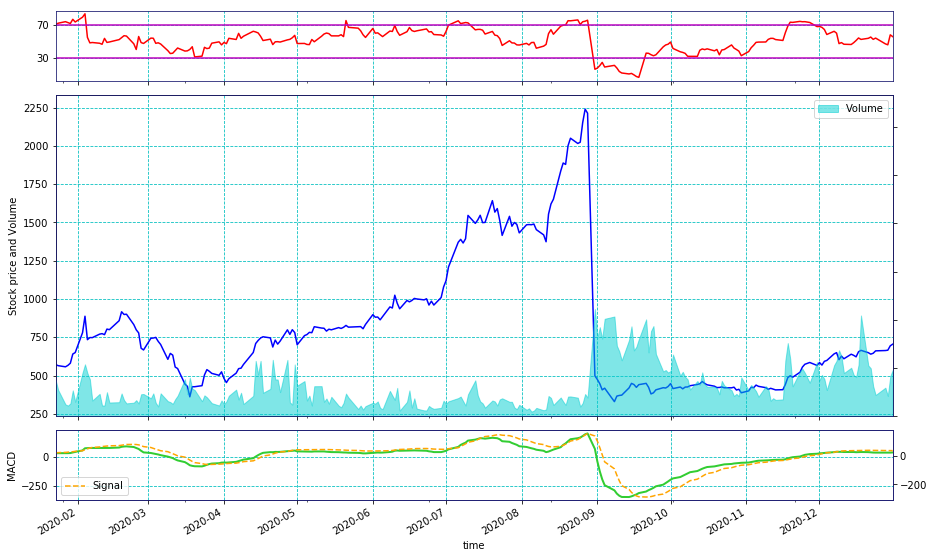

In [36]:
# display technical chart test
stock_prices_for_technical_chart = stock_prices_from_api(["TSLA"],
                                                        "2020-01-01",
                                                        "2021-01-01")
rsi_df = rsi_table(stock_prices_for_technical_chart, 14)

macd_df = macd_table(stock_prices_for_technical_chart, 12, 26, 9)

technical_chart_panel = pn.pane.Matplotlib(display_technical_chart('TSLA', 
                                                         stock_prices_for_technical_chart, 
                                                         rsi_df, 
                                                         macd_df,
                                                         "2020-01-01",
                                                         "2021-01-01"))

## Traditional Portfolio Analysis

In [37]:
# plt.style.use('~/.matplotlib/matplotlibrc-save')

In [38]:
# Automatically re-import python module(s) if they change
%load_ext autoreload
%autoreload 1
%aimport MyPortfolioSimulator

In [39]:
# Import methods from the custom written MyPortfolioSimulator library
from MyPortfolioSimulator import get_tickers
from MyPortfolioSimulator import get_attributes
from MyPortfolioSimulator import get_log_returns
from MyPortfolioSimulator import get_sharpe_ratios
from MyPortfolioSimulator import get_portfolio_return_variance_sharpe
from MyPortfolioSimulator import TraditionalPortfolioAnalyzer

### Notes

#### Logarithmic vs. Fractional Returns

Fractional rate of return of a time series $\{S_t\}_{t=1}^{T}$: 

\begin{equation}
    r^\text{(frac)}_t  \equiv  \frac{S_{t} - S_{t-1}}{S_{t-1}}    \qquad\Longleftrightarrow\qquad
    S_{t}  =  \left( 1  +  r^\text{(frac)}_t \right) S_{t-1}
\end{equation}

Logarithmic rate of return of a time series $\{S_t\}_{t=1}^{T}$: 

\begin{equation}
    r^\text{(log)}_t  \equiv  \ln(S_{t})  -  \ln(S_{t-1})  =  \ln\left( \frac{S_{t}}{S_{t-1}} \right)    \qquad\Longleftrightarrow\qquad
    S_{t}  =  \exp\left( r^\text{(log)}_t \right)  S_{t-1}  
\end{equation}

The formulas for converting back and forth between fractional and logarithmic returns are 

\begin{equation}
    r^\text{(log)}_t  =  \ln\left( \frac{S_{t}}{S_{t-1}} \right)
        =  \ln\left( 1  +  \frac{S_{t} - S_{t-1}}{S_{t-1}} \right)
        =  \ln\left( 1  +  r^\text{(frac)}_t \right)
    \qquad\Longleftrightarrow\qquad
    r^\text{(frac)}_t  =  \exp\left( r^\text{(log)}_t \right)  -  1
\end{equation}

By recursively letting $t \to t-1$ in the above formulas, you get the usual "cumulative product" formulas.  


#### Portfolio Optimization

Expected Portfolio Return: 

\begin{equation}
    \mu_{p}  \equiv  \omega_1 \mu_1  +  \omega_2 \mu_2  +  \cdots  +  \omega_N \mu_N  =  \sum_{i=1}^{N} \omega_i \mu_i  \equiv  \boldsymbol{\omega} \cdot \boldsymbol{\mu}
\end{equation}


Expected Portfolio Variance: 

\begin{equation}
    \Sigma_{p}  \equiv  \boldsymbol{\omega} \cdot \boldsymbol{\Sigma} \cdot \boldsymbol{\omega}  \equiv  \sigma_{p}^2
\end{equation}

### Get Test Data

In [40]:
# Here are the parameters of our test dataset
ntickers = 8  # number of random S&P 500 stocks to use
ndays_calendar = 30  # calendar days, not business days!

# Get data on demand from Alpaca API
tickers = sp500_tickers['Symbol'].sample(ntickers).tolist()
date_end = date.today()
date_begin = date_end - timedelta(ndays_calendar)
df_ohlcv = stock_prices_from_api(tickers, date_begin, date_end)

# Inform user
print('DATA EXPLORATION PARAMETERS')
print('---------------------------')
print(f"tickers: {tickers}")
print(f"date_begin: {date_begin}")
print(f"date_end: {date_end}")
df_ohlcv.head()

DATA EXPLORATION PARAMETERS
---------------------------
tickers: ['APA', 'NOV', 'WLTW', 'ENPH', 'CFG', 'ALXN', 'PWR', 'NTRS']
date_begin: 2021-04-16
date_end: 2021-05-16


ALXN                                        APA  \
                             open     high     low   close   volume     open   
time                                                                           
2021-04-16 00:00:00-04:00  163.91  164.600  163.54  163.68  6166156  18.1925   
2021-04-19 00:00:00-04:00  165.43  165.950  164.51  165.48  3235263  17.9000   
2021-04-20 00:00:00-04:00  165.76  166.810  165.58  166.54  2963227  18.0100   
2021-04-21 00:00:00-04:00  167.67  168.515  167.39  168.41  1600422  16.5000   
2021-04-22 00:00:00-04:00  167.83  168.480  167.02  167.65  1753971  17.2200   

                                                            ...    PWR         \
                              high     low  close   volume  ...   open   high   
time                                                        ...                 
2021-04-16 00:00:00-04:00  18.2731  17.585  17.80  5892581  ...  95.92  96.49   
2021-04-19 00:00:00-04:00  18.3891  17.780  18.08  4447699  ...  96.29  96.48   
2021-04-20 00:00:00-04:00  18.0400  16.755  17.00  9619395  ...  95.29  95.36   
2021-04-21 00:00:00-04:00  17.3000  16.270  17.15  5195215  ...  94.00  95.66   
2021-04-22 00:00:00-04:00  17.7150  16.960  17.61  7325761  ...  95.76  96.77   

                                                     WLTW                  \
                              low  close   volume    open    high     low   
time                                                                        
2021-04-16 00:00:00-04:00  94.630  95.74   807405  242.20  242.20  237.17   
2021-04-19 00:00:00-04:00  95.210  95.85   576058  239.91  240.95  238.00   
2021-04-20 00:00:00-04:00  92.175  93.77  1112194  238.03  239.24  236.24   
2021-04-21 00:00:00-04:00  93.370  95.58   733270  237.46  239.47  235.03   
2021-04-22 00:00:00-04:00  94.850  95.94   626413  234.60  235.01  232.46   

                                           
                            close  volume  
time                                       
2021-04-16 00:00:00-04:00  240.40  523560  
2021-04-19 00:00:00-04:00  238.04  933905  
2021-04-20 00:00:00-04:00  237.27  917926  
2021-04-21 00:00:00-04:00  235.72  488608  
2021-04-22 00:00:00-04:00  233.20  625419  

[5 rows x 40 columns]

### Explore/Test Daily Returns

In [41]:
# Test method `get_tickers()`
tickers_test = get_tickers(df_ohlcv)
assert set(tickers_test) == set(tickers)

# Test method `get_attributes()`
attributes_test = get_attributes(df_ohlcv)
assert attributes_test == df_ohlcv.columns.get_level_values(1).unique().tolist()

# Calculate logarithmic returns
df_log_returns = get_log_returns(df_ohlcv).droplevel(1, axis=1)

# Calculate cumulative returns
df_cum_returns = np.exp(df_log_returns).cumprod() - 1

# Plot Results
pn.Column(
    '# Stock Daily Returns',
    '## Logarithmic Returns',
    '### Histogram',
    df_log_returns.hvplot.hist(
        title = 'Logarithmic Returns',
        xlabel = 'Logarithmic Return (Unitless)',
        ylabel = 'Counts',
        alpha=0.5,
    ),
    '### Violin Plot',
    df_log_returns.hvplot.violin(
        title = 'Logarithmic Returns',
        xlabel = 'Ticker',
        ylabel = 'Logarithmic Return (Unitless)',
    ),
    '### Timeseries',
    df_log_returns.hvplot(
        title='Logarithmic Return vs. Time',
        xlabel = 'Time',
        ylabel = 'Logarithmic Return (Unitless)',
    ),
    '## Cumulative Returns',
    '### Timeseries',
    df_cum_returns.hvplot(
        title='Cumulative Return vs. Time',
        xlabel = 'Time',
        ylabel = 'Cumulative Return (Unitless)',
    )
)

Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Markdown(str)
    [3] HoloViews(NdOverlay)
    [4] Markdown(str)
    [5] HoloViews(Violin)
    [6] Markdown(str)
    [7] HoloViews(NdOverlay)
    [8] Markdown(str)
    [9] Markdown(str)
    [10] HoloViews(NdOverlay)

### Explore/Test Sharpe Ratios

In [42]:
df_sharpe_ratios = get_sharpe_ratios(df_log_returns, risk_free_rate=0.0, periods_per_annum=252).sort_values(ascending=True)
df_sharpe_ratios.hvplot.bar(
    title = 'Annualized Sharpe Ratios',
    xlabel = 'Ticker',
    ylabel = 'Annualized Sharpe Ratio',
)

:Bars   [index]   (0)

### Portfolio Optimization

In [43]:
#===============================================================================
# PRELIMINARIES ----------------------------------------------------------------
#===============================================================================

# For the sake of generating the efficient frontier plot below, only select
# a few financial instruments
nbest_sharpe = min(4, df_sharpe_ratios.size)
tickers_best_sharpe = df_sharpe_ratios.sort_values(ascending=True)[-nbest_sharpe:].index.tolist()

# Create an instance of our class
tpa = TraditionalPortfolioAnalyzer(df_log_returns[tickers_best_sharpe], allow_shorts=False)
num_random_portfolios = 1000  # see below

# Define default plot layout and style
default_plot_cmap = plt.cm.jet  # gnuplot
default_plot_width = 800
default_plot_height = 650
default_plot_title_size = 20
default_plot_label_size = 0.8 * default_plot_title_size
default_plot_tick_size = 0.8 * default_plot_label_size
default_plot_marker_size = 16 ** 2


#===============================================================================
# MAKE PLOTS -------------------------------------------------------------------
#===============================================================================

# These options are common for all plots below
hvplot_kwargs = dict(
    x = 'portfolio_variance',
    y = 'portfolio_return',
    hover_cols = ['descrip', 'portfolio_sharpe_ratio'],
)

tpa_plot_efficient_frontier = tpa.get_random_portfolios(nrandom=num_random_portfolios).hvplot.scatter(
    c = 'portfolio_sharpe_ratio',
    clabel='Annualized Sharpe Ratio (Unitless)',
    s = default_plot_marker_size,
    cmap = default_plot_cmap,
    **hvplot_kwargs
)

# Plot individual stocks -- some are very far away from the efficient frontier
tpa_plot_efficient_frontier *= tpa.get_individual_stock_portfolios().hvplot.scatter(
    c = 'gray',
    s = (1.5 * default_plot_marker_size),
    **hvplot_kwargs
)

# Plot the equal-weight portfolio
tpa_plot_efficient_frontier *= tpa.get_equal_weight_portfolio().hvplot.scatter(
    c = 'k',
    s = (2 * default_plot_marker_size),
    marker = 's',
    **hvplot_kwargs
)

# Finalize plot
tpa_plot_efficient_frontier.opts(
    title = 'Efficient Frontier + Interesting Portfolios',
    xlabel='Expected Annualized Portfolio Variance, σ^2 (Unitless)',
    ylabel='Expected Annualized Portfolio Return, μ (Unitless)',
    width = (1 * default_plot_width),
    height = (1 * default_plot_height),
    fontsize={
        'title': default_plot_title_size, 
        'labels': default_plot_label_size, 
        'xticks': default_plot_tick_size, 
        'yticks': default_plot_tick_size,
    }
)

:Overlay
   .Scatter.I   :Scatter   [portfolio_variance]   (portfolio_return,portfolio_sharpe_ratio,descrip)
   .Scatter.II  :Scatter   [portfolio_variance]   (portfolio_return,descrip,portfolio_sharpe_ratio)
   .Scatter.III :Scatter   [portfolio_variance]   (portfolio_return,descrip,portfolio_sharpe_ratio)

## Hierarchical Portfolio Allocation

For the Hierarchical-Clustering plots, it helps to have a lot of tickers in the dataframe.  To this end, load data from file `./resources/price_data.csv` and choose ~30 financial instruments

In [44]:
# Load raw data and calculate logarithmic returns
df_hierarchical_returns = get_log_returns(pd.read_csv('./resources/price_data.csv', header=[0, 1], index_col=0).sort_index(ascending=True)).droplevel(1, axis=1)

# Drop columns with NaNs
columns_with_NaNs = np.where(df_hierarchical_returns.isna().sum(axis=0).values != 0, True, False)
df_hierarchical_returns = df_hierarchical_returns.iloc[:, ~columns_with_NaNs]

# Randomly choose a subset of tickers
num_instruments = 21
df_hierarchical_returns = df_hierarchical_returns.sample(n=num_instruments, axis=1)

### Correlation Matrix

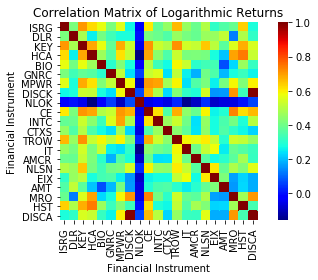

In [45]:
# Get correlation matrix
df_hierarchical_returns_corr = df_hierarchical_returns.corr()

# Plot correlation matrix with `matplotlib.pyplot`
fig, ax = plt.subplots()  #figsize=(8, 8))
sns.heatmap(
    df_hierarchical_returns_corr,
    ax=ax,
    cmap=default_plot_cmap,
    square=True,
    xticklabels = 1,  # don't skip any labels
    yticklabels = 1,
)
ax.set_xticklabels(ax.get_xmajorticklabels())
ax.set_yticklabels(ax.get_ymajorticklabels())
ax.set_title('Correlation Matrix of Logarithmic Returns')
ax.set_xlabel('Financial Instrument')
ax.set_ylabel('Financial Instrument')
plt.tight_layout()
if 0:
    fig.savefig('./images/correlation-matrix.png', dpi=300)

# Convert to `panel`
hvplot_corr = pn.pane.Matplotlib(fig)

### Eigenvalues of Correlation Matrix

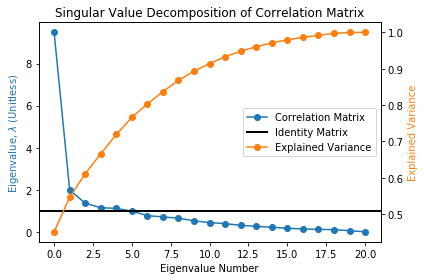

In [46]:
# Perform SVD of correlation matrix
UU, eigvals, VVT = np.linalg.svd(df_hierarchical_returns_corr, full_matrices=False)

# Plot results
fig, ax = plt.subplots()
line1 = ax.plot(eigvals, 'o-', color='C0', label='Correlation Matrix')
line2 = ax.axhline(y=1, linestyle='-', color='k', lw=2, label='Identity Matrix')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Eigenvalue, $\lambda$ (Unitless)', color='C0')
ax.grid(False)

ax = ax.twinx()

line3 = ax.plot((np.cumsum(eigvals) / np.sum(eigvals)), 'o-', c='C1', label='Explained Variance')
ax.set_title('Singular Value Decomposition of Correlation Matrix')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Explained Variance', color='C1')
#ax.grid(False)

ax.legend(line1 + [line2] + line3, ['Correlation Matrix', 'Identity Matrix', 'Explained Variance'], loc='center right')
plt.tight_layout()
plt.show()

if 0:
    fig.savefig('./images/correlation-matrix-svd.png', dpi=300)

hvplot_corr_eigvals = pn.pane.Matplotlib(fig)

#### Distance Matrix

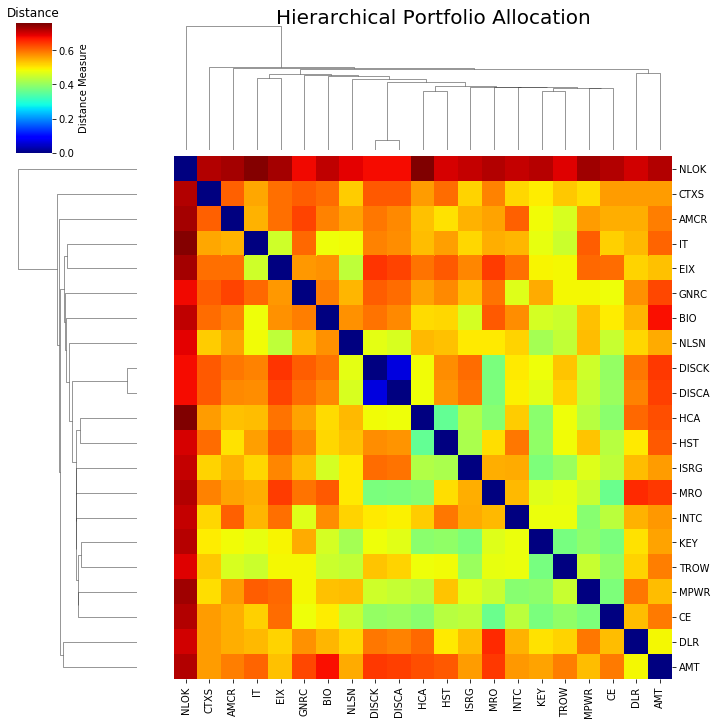

In [47]:
# Calculate distance matrix
df_hierarchical_returns_distance_matrix = np.sqrt((1 - df_hierarchical_returns_corr) / 2)

# Plot clustermap
clusterplot = sns.clustermap(
    df_hierarchical_returns_distance_matrix,
    method='single',
    metric='euclidean',
    cmap=default_plot_cmap,
    square=True,
    xticklabels = 1,  # don't skip any labels
    yticklabels = 1,
    cbar_kws={'label': 'Distance Measure'}
)
clusterplot.cax.set_title('Distance')
clusterplot.fig.suptitle('Hierarchical Portfolio Allocation', x=0.6, y=1.0, ha='center', fontsize=20)
hvplot_hierarchical = pn.pane.Matplotlib(clusterplot.fig)

### Example Panel Construction

Column
    [0] Markdown(str)
    [1] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
    [2] Markdown(str)
    [3] Matplotlib(Figure)
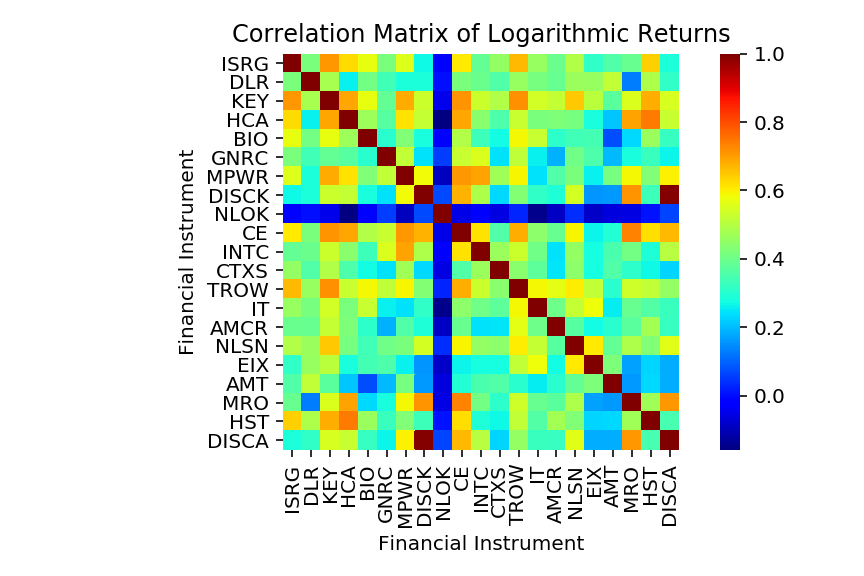
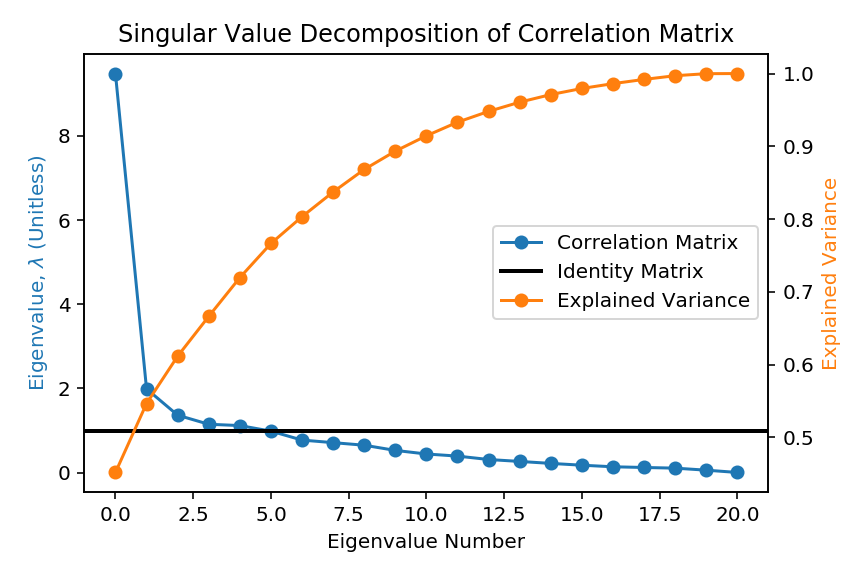
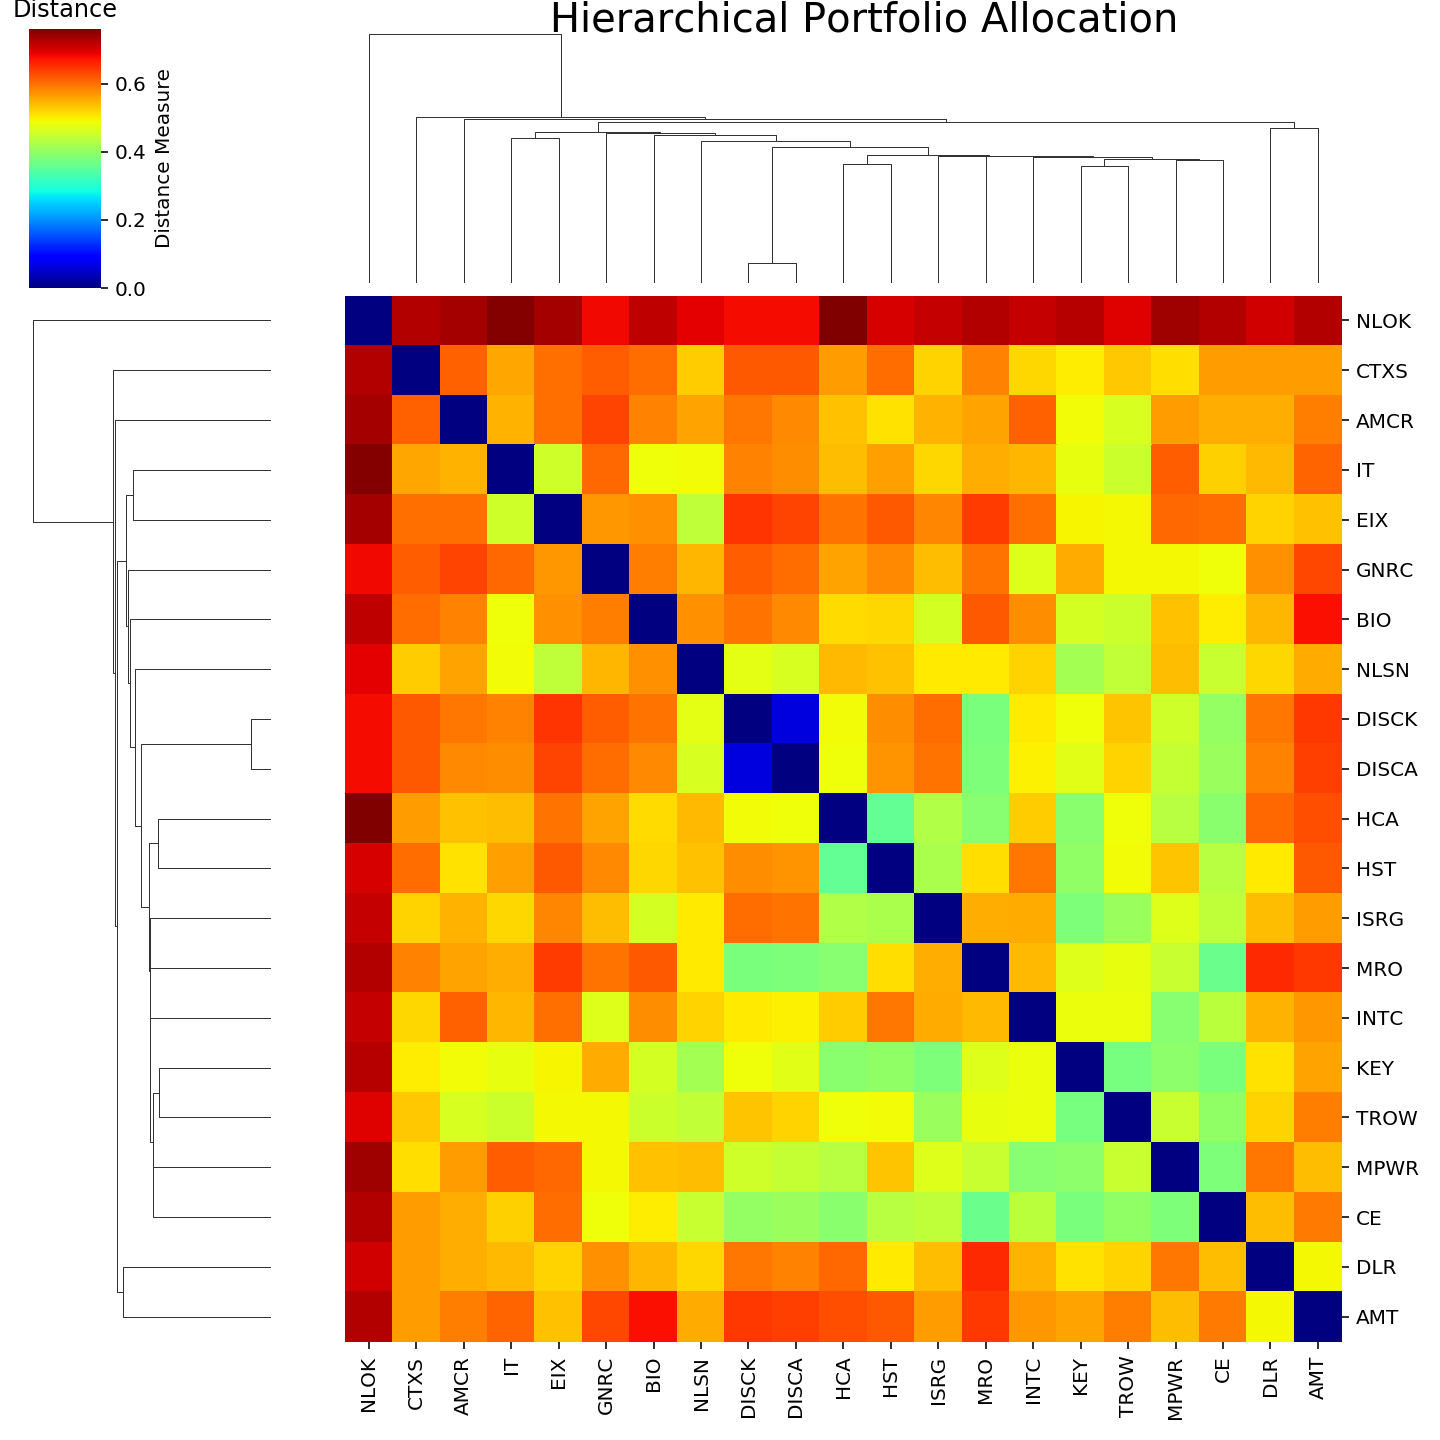

In [48]:
pn.Column(
    '# Correlation-Matrix Analysis',
    pn.Row(
        hvplot_corr,
        hvplot_corr_eigvals
    ),
    '# Hierarchical Clustering',
    hvplot_hierarchical,
)